In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### 1.Loading Data

In [3]:
dat0 = pd.read_csv('rusdata_new_long.csv',encoding='latin1')

In [4]:
dat0.head(5)

launched     e_day  days_elec_abs  days_elec_pminus  bin_before  \
0   2/20/17  11/8/16            104              -104           0   
1   10/3/16  11/8/16             36                36           1   
2   5/12/16  11/8/16            180               180           1   
3   5/12/16  11/8/16            180               180           1   
4   5/12/16  11/8/16            180               180           1   

   days_elec_flip    medium  medium_bin  \
0             104  Facebook           1   
1             -36  Facebook           1   
2            -180  Facebook           1   
3            -180  Facebook           1   
4            -180  Facebook           1   

                                                text  \
0        God Bless Dixie! The South will rise again!   
1                                  Stop Islamophobia   
2  Only for Chrome users! Any music via "FaceMusi...   
3  Only for Chrome users! Any music via "FaceMusi...   
4  Free online player! Just add in ur browser and...   

                                            landpage  ...  \
0  https://www .facebook.com/South-United-1777037...  ...   
1            https://www.facebook.com/MuslimAmerica/  ...   
2                               https:Hmusicfb.info/  ...   
3                               https:Hmusicfb.info/  ...   
4                              https://musicfb.info/  ...   

   Mexico.Hispanicculture  Interests:.AppleMusic  \
0                       0                      0   
1                       0                      0   
2                       0                      0   
3                       0                      0   
4                       0                      0   

   People Who Match:.LawEnforcementLife  Interests:.Kemetism  \
0                                     0                    0   
1                                     0                    0   
2                                     0                    0   
3                                     0                    0   
4                                     0                    0   

  Facebook access (mobile):.allmobiledevices Gender:.Female  \
0                                          0              0   
1                                          0              0   
2                                          0              0   
3                                          0              0   
4                                          0              0   

   Interests:.AlJazeera  Age:.16-40  \
0                     0           0   
1                     0           0   
2                     0           0   
3                     0           0   
4                     0           0   

   United States:.BaltimoreMaryland;Ferguson  on pages:.InstagramFeed  
0                                          0                        0  
1                                          0                        0  
2                                          0                        0  
3                                          0                        0  
4                                          0                        0  

[5 rows x 1448 columns]

### 2.Data Cleaning, delete not useful columns

In [5]:
continuous_des_df=dat0.describe().T.reset_index()
continuous_des_df.head(5)

index   count        mean         std    min    25%    50%  \
0     days_elec_abs  2603.0  187.817518  132.017244    0.0   98.0  169.0   
1  days_elec_pminus  2603.0   84.545140  213.464054 -278.0 -125.0   47.0   
2        bin_before  2603.0    0.588167    0.492260    0.0    0.0    1.0   
3    days_elec_flip  2603.0  -84.545140  213.464054 -518.0 -211.0  -47.0   
4        medium_bin  2603.0    0.963504    0.187558    0.0    1.0    1.0   

     75%    max  
0  211.0  518.0  
1  211.0  518.0  
2    1.0    1.0  
3  125.0  278.0  
4    1.0    1.0

In [6]:
###  std = 0 means no effects for model, so we can delete it
drop_continuous_cols=continuous_des_df[continuous_des_df['std']==0]["index"].values.tolist()
print("drop continuous cols number:",len(drop_continuous_cols))
dat1=dat0.drop(columns=drop_continuous_cols)

drop continuous cols number: 108


In [7]:
discrete_des_df=dat1.describe(include=["O"]).T.reset_index()
discrete_des_df.head(5)

index count unique                                                top  \
0  launched   2603    347                                            4/13/16   
1      e_day  2603      1                                            11/8/16   
2     medium  2603      2                                           Facebook   
3       text  2567   2122                                             repost   
4   landpage  2580    488  https://www.facebook.com/Black-Matters-1579673...   

   freq  
0    78  
1  2603  
2  2508  
3    36  
4   203

In [8]:
### delete column which unique = 1
drop_discrete_cols=discrete_des_df[discrete_des_df['unique']==1]["index"].values.tolist()
print("drop discrete cols number:",len(drop_discrete_cols))
dat2=dat1.drop(columns=drop_discrete_cols)

drop discrete cols number: 1


In [9]:
# Delete columns
cols = ['launched ','impress','bdate','enddate','medium','landpage']
dat3 = dat2.drop(cols, axis=1)

### 3.Analyzing the correlation

In [10]:
#Check the correlation
high_corr_df=dat3.corr()['clicks'].abs().sort_values(ascending=False)
high_corr_df.head(10)

clicks                                        1.000000
spend                                         0.653975
Interests:.SheriffsintheUnitedStates          0.364211
Interests:.LawenforcementintheUnitedStates    0.364211
Age:.20-65+                                   0.252470
Age:.16-65+                                   0.220399
Interests:.Statepolice                        0.202056
Interests:.AmericanCivilWar                   0.196776
Interests:.Blacknationalism                   0.176205
Mexico.Lowrider                               0.173812
Name: clicks, dtype: float64

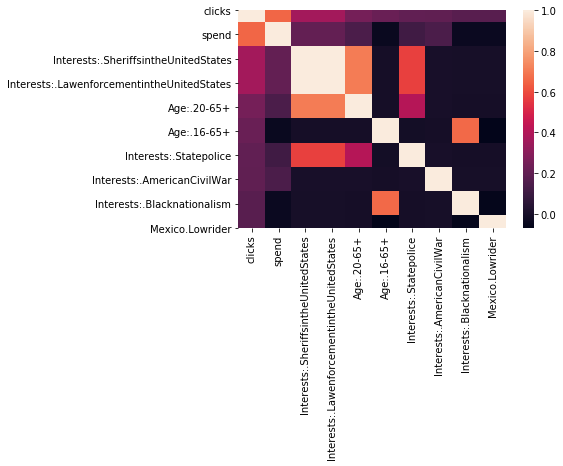

In [11]:
#heat map
high_corr_cols=high_corr_df.reset_index()['index'].values.tolist()[:10]
sns.heatmap(dat3[high_corr_cols].corr())

### 4.USE 3 models to test data after drop cloumns

In [19]:
 ### change missing value to 0
dat4=dat3.fillna(0)

In [20]:
dat4.head(5)

days_elec_abs  days_elec_pminus  bin_before  days_elec_flip  medium_bin  \
0            104              -104           0             104           1   
1             36                36           1             -36           1   
2            180               180           1            -180           1   
3            180               180           1            -180           1   
4            180               180           1            -180           1   

                                                text  clicks       ctr  spend  \
0        God Bless Dixie! The South will rise again!       0  0.000000    0.0   
1                                  Stop Islamophobia       0  0.000000    0.0   
2  Only for Chrome users! Any music via "FaceMusi...       1  0.003984    0.0   
3  Only for Chrome users! Any music via "FaceMusi...       0  0.000000    0.0   
4  Free online player! Just add in ur browser and...       0  0.000000    0.0   

   clength  ...  Mexico.Hispanicculture  Interests:.AppleMusic  \
0      0.0  ...                       0                      0   
1      0.0  ...                       0                      0   
2      0.0  ...                       0                      0   
3      0.0  ...                       0                      0   
4      0.0  ...                       0                      0   

   People Who Match:.LawEnforcementLife  Interests:.Kemetism  \
0                                     0                    0   
1                                     0                    0   
2                                     0                    0   
3                                     0                    0   
4                                     0                    0   

   Facebook access (mobile):.allmobiledevices  Gender:.Female  \
0                                           0               0   
1                                           0               0   
2                                           0               0   
3                                           0               0   
4                                           0               0   

   Interests:.AlJazeera  Age:.16-40  \
0                     0           0   
1                     0           0   
2                     0           0   
3                     0           0   
4                     0           0   

   United States:.BaltimoreMaryland;Ferguson  on pages:.InstagramFeed  
0                                          0                        0  
1                                          0                        0  
2                                          0                        0  
3                                          0                        0  
4                                          0                        0  

[5 rows x 1333 columns]

In [21]:
del dat4['text']

In [22]:
### save data
dat4.to_csv("dat4.csv",index=False)

In [23]:
### traning model, got r^2
dat4_y=dat4['clicks']
dat4_x=dat4.drop(columns=['clicks'])

In [24]:

X_train,X_test, y_train, y_test =train_test_split(dat4_x,dat4_y,test_size=0.2, random_state=42)
X_train,X_val, y_train, y_val =train_test_split(X_train,y_train,test_size=0.2, random_state=42)

In [25]:
#RandomForestRegressor
kfold= KFold(n_splits=5,shuffle=True)
validation_scores=[]
cross_validation_scores=[]
test_scores=[]
for train_index,test_index in kfold.split(X_train,y_train):
    xx_train=X_train.iloc[train_index]
    yy_train=y_train.iloc[train_index]
    xx_test=X_train.iloc[test_index]
    yy_test=y_train.iloc[test_index]
    
    regressor = RandomForestRegressor()
    regressor.fit(xx_train, yy_train)
    yy_pre=regressor.predict(xx_test)
    y_val_pre=regressor.predict(X_val)
    y_pre=regressor.predict(X_test)
    cross_validation_scores.append(r2_score(yy_test,yy_pre))
    validation_scores.append(r2_score(y_val,y_val_pre))
    test_scores.append(r2_score(y_test,y_pre))
print('cross validation:',np.mean(cross_validation_scores),'validation:',np.mean(validation_scores),'holdout:',np.mean(test_scores))

cross validation: 0.12182385302182867 validation: 0.34446324185107846 holdout: 0.30262125897537634


In [26]:
#LassoLarsCV
kfold= KFold(n_splits=5,shuffle=True)
validation_scores=[]
cross_validation_scores=[]
test_scores=[]
for train_index,test_index in kfold.split(X_train,y_train):
    xx_train=X_train.iloc[train_index]
    yy_train=y_train.iloc[train_index]
    xx_test=X_train.iloc[test_index]
    yy_test=y_train.iloc[test_index]
    
    regressor = LassoLarsCV()
    regressor.fit(xx_train, yy_train)
    yy_pre=regressor.predict(xx_test)
    y_val_pre=regressor.predict(X_val)
    y_pre=regressor.predict(X_test)
    cross_validation_scores.append(r2_score(yy_test,yy_pre))
    validation_scores.append(r2_score(y_val,y_val_pre))
    test_scores.append(r2_score(y_test,y_pre))
print('cross validation:',np.mean(cross_validation_scores),'validation:',np.mean(validation_scores),'holdout:',np.mean(test_scores))

cross validation: 0.4664553341909151 validation: 0.3758225426504546 holdout: 0.31171201871434207


In [27]:
#GradientBoostingRegressor
kfold= KFold(n_splits=5,shuffle=True)
validation_scores=[]
cross_validation_scores=[]
test_scores=[]
for train_index,test_index in kfold.split(X_train,y_train):
    xx_train=X_train.iloc[train_index]
    yy_train=y_train.iloc[train_index]
    xx_test=X_train.iloc[test_index]
    yy_test=y_train.iloc[test_index]
    
    regressor = GradientBoostingRegressor()
    regressor.fit(xx_train, yy_train)
    yy_pre=regressor.predict(xx_test)
    y_val_pre=regressor.predict(X_val)
    y_pre=regressor.predict(X_test)
    cross_validation_scores.append(r2_score(yy_test,yy_pre))
    validation_scores.append(r2_score(y_val,y_val_pre))
    test_scores.append(r2_score(y_test,y_pre))
print('cross validation:',np.mean(cross_validation_scores),'validation:',np.mean(validation_scores),'holdout:',np.mean(test_scores))

cross validation: 0.25698043758476 validation: 0.2674184634121739 holdout: 0.23990476994843218


### 5.Only keep first 50 cloumns which have the most correlation

In [37]:
top50=high_corr_df.reset_index()['index'].values.tolist()[:51]

dat5=dat4[top50+['toxic']]

In [38]:
#save data
dat5.to_csv("dat5.csv",index=False)

In [39]:
### traning data,got r^2
dat5_y=dat5['clicks']
dat5_x=dat5.drop(columns=['clicks'])

In [40]:

X_train,X_test, y_train, y_test =train_test_split(dat5_x,dat5_y,test_size=0.2, random_state=42)
X_train,X_val, y_train, y_val =train_test_split(X_train,y_train,test_size=0.2, random_state=42)

In [34]:
#RandomForestRegressor
kfold= KFold(n_splits=5,shuffle=True)
validation_scores=[]
cross_validation_scores=[]
test_scores=[]
for train_index,test_index in kfold.split(X_train,y_train):
    xx_train=X_train.iloc[train_index]
    yy_train=y_train.iloc[train_index]
    xx_test=X_train.iloc[test_index]
    yy_test=y_train.iloc[test_index]
    
    regressor = RandomForestRegressor()
    regressor.fit(xx_train, yy_train)
    yy_pre=regressor.predict(xx_test)
    y_val_pre=regressor.predict(X_val)
    y_pre=regressor.predict(X_test)
    cross_validation_scores.append(r2_score(yy_test,yy_pre))
    validation_scores.append(r2_score(y_val,y_val_pre))
    test_scores.append(r2_score(y_test,y_pre))
print('cross validation:',np.mean(cross_validation_scores),'validation:',np.mean(validation_scores),'holdout:',np.mean(test_scores))

cross validation: 0.47297037014124976 validation: 0.49169986593261045 holdout: 0.39558742596034807


In [35]:
#LassoLarsCV
kfold= KFold(n_splits=5,shuffle=True)
validation_scores=[]
cross_validation_scores=[]
test_scores=[]
for train_index,test_index in kfold.split(X_train,y_train):
    xx_train=X_train.iloc[train_index]
    yy_train=y_train.iloc[train_index]
    xx_test=X_train.iloc[test_index]
    yy_test=y_train.iloc[test_index]
    
    regressor = LassoLarsCV()
    regressor.fit(xx_train, yy_train)
    yy_pre=regressor.predict(xx_test)
    y_val_pre=regressor.predict(X_val)
    y_pre=regressor.predict(X_test)
    cross_validation_scores.append(r2_score(yy_test,yy_pre))
    validation_scores.append(r2_score(y_val,y_val_pre))
    test_scores.append(r2_score(y_test,y_pre))
print('cross validation:',np.mean(cross_validation_scores),'validation:',np.mean(validation_scores),'holdout:',np.mean(test_scores))

cross validation: 0.49266871901735676 validation: 0.42301984905949847 holdout: 0.37028359362057817


In [36]:
#GradientBoostingRegressor
kfold= KFold(n_splits=5,shuffle=True)
validation_scores=[]
cross_validation_scores=[]
test_scores=[]
for train_index,test_index in kfold.split(X_train,y_train):
    xx_train=X_train.iloc[train_index]
    yy_train=y_train.iloc[train_index]
    xx_test=X_train.iloc[test_index]
    yy_test=y_train.iloc[test_index]
    
    regressor = GradientBoostingRegressor()
    regressor.fit(xx_train, yy_train)
    yy_pre=regressor.predict(xx_test)
    y_val_pre=regressor.predict(X_val)
    y_pre=regressor.predict(X_test)
    cross_validation_scores.append(r2_score(yy_test,yy_pre))
    validation_scores.append(r2_score(y_val,y_val_pre))
    test_scores.append(r2_score(y_test,y_pre))
print('cross validation:',np.mean(cross_validation_scores),'validation:',np.mean(validation_scores),'holdout:',np.mean(test_scores))

cross validation: 0.42461523723857975 validation: 0.4293461001325981 holdout: 0.1998493978966632


### 6.Adding new features

In [41]:
dat6=dat5.copy()

In [42]:
#1.got important "words"
def extrac_text(text):
    text=str(text)
    if "chrome" in text:
        return 1
    elif "great" in text:
        return 2
    elif "free" in text:
        return 3
    else:
        return 0
dat6["text_level"]=dat0["text"].apply(extrac_text)

In [43]:
#average of interests
intests_cols=[]
for col in dat0.columns:
    if "Interests" in col:
        intests_cols.append(col)
len(intests_cols)

805

In [53]:
dat6["Interestd_average"]=dat0[intests_cols].values.mean(axis=1)

In [54]:
# estimate the age
age_cols=[]
for col in dat0.columns:
    if "Age" in col:
        age_cols.append(col)
age_cols[:5]

['Age:.18-65+',
 'Age:.24-65+',
 'Age:.25-65+',
 'Age:.18-50PlacementsNewsFeedondesktopcomputers',
 'Age:.18-39']

In [55]:
for col in age_cols:
    age_range=col.split(":.")[1]
    arrs=age_range.split("-")
    if len(arrs)>1:
        min_age=int(arrs[0])
        max_age=int(arrs[1][:2])
        dat0[col]=dat0[col]*((min_age+max_age)//2)
    else:
        dat0[col]=0

In [56]:
dat6['age_estimate']=dat0[age_cols].sum(axis=1)

In [57]:
dat6['age_estimate'].head(5)

0    1681
1     961
2     484
3     484
4     484
Name: age_estimate, dtype: int64

In [58]:
#Then group by age
dat6['age_level']=dat6['age_estimate']//10

In [59]:
#Group ctr
def extract_ctr(ctr):
    if ctr<0.05:
        return 0
    elif 0.05<=ctr<1:
        return 1
    elif 1<=ctr<2:
        return 2
    elif ctr>=2:
        return 3
    else:
        return -1
dat6['ctr_level']=dat0['ctr'].apply(extract_ctr)

In [60]:
#group target_count
def extract_target_count(x):
    if x<10:
        return 0
    elif x>=10:
        return 1
dat6['target_count_level']=dat0["target_count"].apply(extract_target_count)

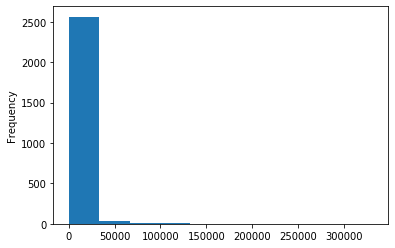

In [61]:
#Group spend
dat6['spend'].plot(kind='hist')

In [62]:
#yse log spend 
dat6['spend_log']=np.log1p(dat6['spend'])

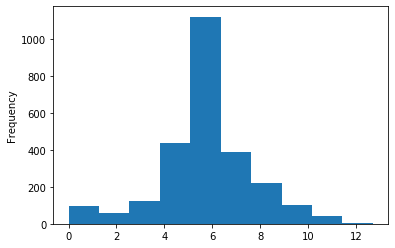

In [63]:
dat6['spend_log'].plot(kind='hist')

In [64]:
#spend_level
def extract_spend_level(x):
    if 0<x<127:
        return 1
    elif 127<=x<300:
        return 2
    elif 300<=x<769:
        return 3
    elif 769<=x<30000:
        return 4
    elif x>=30000:
        return 5
    else:
        return 0
dat6['spend_level']=dat6['spend'].apply(extract_spend_level)

In [65]:
#spend_level2
def extract_spend_level2(x):
    if 0<x<200:
        return 1
    elif 200<=x<400:
        return 2
    elif 400<=x<600:
        return 3
    elif 600<=x<800:
        return 4
    elif 800<x:
        return 5
    else:
        return 0
dat6['spend_level2']=dat6['spend'].apply(extract_spend_level2)

In [66]:
dat6.fillna(0,inplace=True)
dat6.to_csv("dat6.csv",index=False)

In [67]:

dat6_y=dat6['clicks']
dat6_x=dat6.drop(columns=['clicks'])

In [68]:

X_train,X_test, y_train, y_test =train_test_split(dat6_x,dat6_y,test_size=0.2, random_state=42)
X_train,X_val, y_train, y_val =train_test_split(X_train,y_train,test_size=0.2, random_state=42)

In [69]:
#RandomForestRegressor
kfold= KFold(n_splits=5,shuffle=True)
validation_scores=[]
cross_validation_scores=[]
test_scores=[]
for train_index,test_index in kfold.split(X_train,y_train):
    xx_train=X_train.iloc[train_index]
    yy_train=y_train.iloc[train_index]
    xx_test=X_train.iloc[test_index]
    yy_test=y_train.iloc[test_index]
    
    regressor = RandomForestRegressor()
    regressor.fit(xx_train, yy_train)
    yy_pre=regressor.predict(xx_test)
    y_val_pre=regressor.predict(X_val)
    y_pre=regressor.predict(X_test)
    cross_validation_scores.append(r2_score(yy_test,yy_pre))
    validation_scores.append(r2_score(y_val,y_val_pre))
    test_scores.append(r2_score(y_test,y_pre))
print('cross validation:',np.mean(cross_validation_scores),'validation:',np.mean(validation_scores),'holdout:',np.mean(test_scores))

cross validation: 0.4390526017002383 validation: 0.5034468961328789 holdout: 0.36583842757239465


In [70]:
#LassoLarsC
kfold= KFold(n_splits=5,shuffle=True)
validation_scores=[]
cross_validation_scores=[]
test_scores=[]
for train_index,test_index in kfold.split(X_train,y_train):
    xx_train=X_train.iloc[train_index]
    yy_train=y_train.iloc[train_index]
    xx_test=X_train.iloc[test_index]
    yy_test=y_train.iloc[test_index]
    
    regressor = LassoLarsCV()
    regressor.fit(xx_train, yy_train)
    yy_pre=regressor.predict(xx_test)
    y_val_pre=regressor.predict(X_val)
    y_pre=regressor.predict(X_test)
    cross_validation_scores.append(r2_score(yy_test,yy_pre))
    validation_scores.append(r2_score(y_val,y_val_pre))
    test_scores.append(r2_score(y_test,y_pre))
print('cross validation:',np.mean(cross_validation_scores),'validation:',np.mean(validation_scores),'holdout:',np.mean(test_scores))

cross validation: 0.4543930358667921 validation: 0.4387928266534325 holdout: 0.3778350984325066


In [71]:
#GradientBoostingRegressor
kfold= KFold(n_splits=5,shuffle=True)
validation_scores=[]
cross_validation_scores=[]
test_scores=[]
for train_index,test_index in kfold.split(X_train,y_train):
    xx_train=X_train.iloc[train_index]
    yy_train=y_train.iloc[train_index]
    xx_test=X_train.iloc[test_index]
    yy_test=y_train.iloc[test_index]
    
    regressor = GradientBoostingRegressor()
    regressor.fit(xx_train, yy_train)
    yy_pre=regressor.predict(xx_test)
    y_val_pre=regressor.predict(X_val)
    y_pre=regressor.predict(X_test)
    cross_validation_scores.append(r2_score(yy_test,yy_pre))
    validation_scores.append(r2_score(y_val,y_val_pre))
    test_scores.append(r2_score(y_test,y_pre))
print('cross validation:',np.mean(cross_validation_scores),'validation:',np.mean(validation_scores),'holdout:',np.mean(test_scores))

cross validation: 0.5321656178224358 validation: 0.4298795280074163 holdout: 0.2521403770351327


In [72]:
#correlations
X_test['clicks']=y_pre
show_corr=X_test.corr()

In [74]:
show_corr.to_csv("corr.csv",index=False)

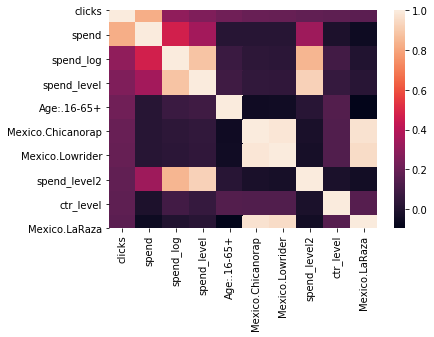

In [75]:

high_corr_df=show_corr['clicks'].abs().sort_values(ascending=False)
high_corr_cols=high_corr_df.reset_index()['index'].values.tolist()[:10]
sns.heatmap(X_test[high_corr_cols].corr())